In [1]:
import io
import os
import requests
import pathlib
import gzip
import glob

import pandas as pd
import numpy as np

import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

import imageio
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Load segmentor models.

In [2]:
NUC_MODEL = 'saved-model/nuclei-model.pth'
CELL_MODEL = 'saved-model/cell-model.pth'

In [3]:
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=False,
    multi_channel_model=True,
)

please compile abn


## Test a sample for the visualization of combined image and masks

In [7]:
image_id = "00b9bdcc-bbca-11e8-b2bc-ac1f6b6435d0"
mt = glob.glob(f"data/train/{image_id}_red.png")
er = [f.replace('red', 'yellow') for f in mt]
nu = [f.replace('red', 'blue') for f in mt]
images = [mt, er, nu]

images

[['data/train/00b9bdcc-bbca-11e8-b2bc-ac1f6b6435d0_red.png'],
 ['data/train/00b9bdcc-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png'],
 ['data/train/00b9bdcc-bbca-11e8-b2bc-ac1f6b6435d0_blue.png']]

In [8]:
# For nuclei
nuc_segmentations = segmentator.pred_nuclei(images[2])
# For full cells
cell_segmentations = segmentator.pred_cells(images)

In [10]:
save_dir = os.path.join(os.getcwd(),'data/train')
# post-processing
for i, pred in enumerate(cell_segmentations):
    nuclei_mask, cell_mask = label_cell(nuc_segmentations[i], cell_segmentations[i])
    FOVname = os.path.basename(mt[i]).replace('red','predictedmask')
    imageio.imwrite(os.path.join(save_dir,FOVname), cell_mask) 

### Visualizing the segmentation masks from the images

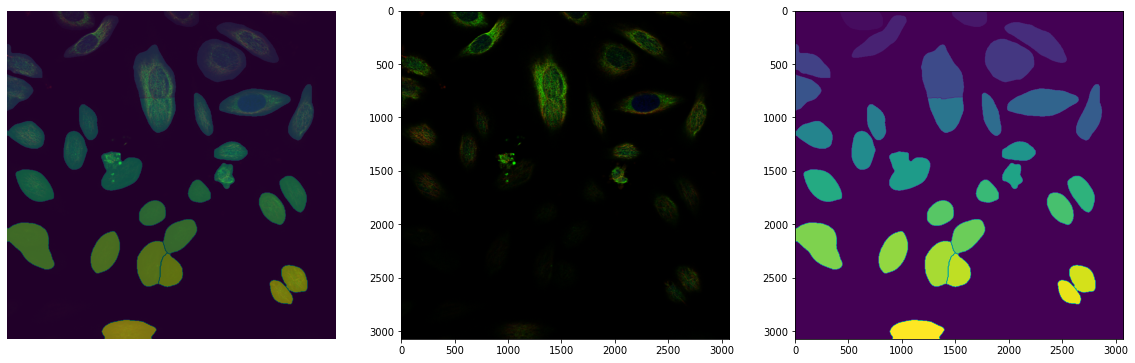

In [11]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(1):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    mask = plt.imread(mt[i].replace('red','predictedmask'))
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    ax[i].imshow(img)
    ax[i].imshow(mask, alpha=0.5)
    ax[i].axis('off')
    ax[1].imshow(img)
    ax[2].imshow(mask)
    
plt.show()

In [12]:
df = pd.read_csv("train.csv")

In [13]:
df.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [14]:
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=False,
    multi_channel_model=True,
)

## Prepare images data for the segmentator

In [15]:
def get_image_data_from_df(df):
    mt = []
    er = []
    nu = []
    gr = []
    lbl = []
    ids = []

    for (idx, row) in df.iterrows():
        image_id = row["id"]
        mt.append(f"{src}{image_id}_red.png")
        er.append(f"{src}{image_id}_yellow.png")
        nu.append(f"{src}{image_id}_blue.png")
        gr.append(f"{src}{image_id}_green.png")
        lbl.append(row["class"])
        ids.append(image_id)
    
    return [mt, er, nu, gr, lbl, ids]

In [16]:
print(get_image_data_from_df(df_images))

NameError: name 'df_images' is not defined

## Helper functions to segment and save the individual cell images

In [29]:
def get_Segmentations(images):
    # For nuclei
    nuc_segmentations = segmentator.pred_nuclei(images[2])
    # For full cells
    cell_segmentations = segmentator.pred_cells(images)
    
    return (nuc_segmentations, cell_segmentations)

# Creat empty mask grid number of cells identified in the segmentation
def get_empty_mask_dict(count, shape):
    mask_dict = {}
    for val in range(count):
        index = val+1
        mask_dict[index] = np.zeros(shape)

    return mask_dict

# Based on the image mask, isolate the green image. Shrink the image to have only the mask is available and the save.
def save_split_files(mask_dict, green_image, label, pd_id, pd_dict):
    local_index = 0
    #img_uint8 = img.astype(np.uint8)
    for key, value in mask_dict.items():
        final_img = green_image * value
        y_nonzero, x_nonzero= np.nonzero(final_img)
        
        # Crop the image based on the mask coordinates
        cropped_image = final_img[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

        # create finale image and save
        file_name = f"{dest}{pd_id}_{label}_{local_index}.png"
        imageio.imwrite(file_name, cropped_image)
        
        # update metadata for the saved file
        pd_dict["id"].append(file_name)
        pd_dict["label"].append(label)
        local_index += 1

# Code function to get segments and split the green files based on the masks obtained

In [32]:
# given a source, dest folder and dataframe of the source images, process them and create segmented cell images
def convert_to_cell_cropped_images(src, dest, df):
    images = get_image_data_from_df(df)
    pd_dict  = {'id':[],'label':[]}
    
    total = len(df)
    processed = 0
    current = 1
    pd_id = ""
    for index in range(len(images[0])):
        try:
            # For each image capture the red,yellow, blue and the greeimage.
            # First 3 images are used for cell segmentation mask.
            # The obtained cell segmentation mask is used on the gree imaged to isolcate the individual cells
            to_process_images = [[],[],[]]
            to_process_images[0].append(images[0].pop())
            to_process_images[1].append(images[1].pop())
            to_process_images[2].append(images[2].pop())

            green_image_name = images[3].pop()
            green_image_content = imageio.imread(green_image_name)

            # label image(this code was intende to run only on the images with single type of the cells)
            label = images[4].pop()
            pd_id = images[5].pop()

            # processing takes times and if its stopped in the middle, this code will help skip processing the files that are already done.
            if os.path.isfile(f"{dest}{pd_id}_{label}_0.png"):
                processed +=1
                if processed % 500 == 0:
                    print(f"Processed already {processed} files")
                continue
            
            # Get cell segmentations based on the tool models provided
            nuc_segmentations, cell_segmentations = get_Segmentations(to_process_images)
            
            for i, pred in enumerate(cell_segmentations):
                nuclei_mask, cell_mask = label_cell(nuc_segmentations[i], cell_segmentations[i])

                max_mask_value = np.amax(cell_mask)

                mask_dict = get_empty_mask_dict(max_mask_value, cell_mask.shape)

                for r in range(0, cell_mask.shape[0]):
                    for c in range(0, cell_mask.shape[1]):
                        if cell_mask[r,c] != 0:
                            mask_index = cell_mask[r,c]
                            mask_dict[mask_index][r,c] = 1

                save_split_files(mask_dict, green_image_content, label, pd_id, pd_dict)
            if current % 10 == 0:
                print(f"{current+processed} of Total {total} completed")
            current +=1
        except:
            print(f"Errored file: {pd_id}")
        
    return pd_dict

### Run this following to break the images from picuture to single cells

In [ ]:
%%time
src = "train/"
dest = "train-single/"
resut = convert_to_cell_cropped_images(src, dest, df)

In [86]:
train_signle_df = pd.DataFrame(resut)

In [87]:
train_signle_df.to_csv("train-single.csv")